In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
        recall_score, classification_report, precision_recall_curve,\
        confusion_matrix, auc, roc_curve

In [3]:
from lightgbm import LGBMClassifier
import lightgbm
import  catboost as catb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [4]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#from sklearn.impute import KNNImputer

In [6]:
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#import category_encoders as ce

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [9]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [10]:
def balance_df_by_target_advance(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [11]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
def choise_features(data, model):
    X = data.drop(columns=['target'])
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #lgb = LGBMClassifier(objective='binary',
     ##                   #n_estimators=50, 
    #                     #max_depth=3, 
    #                     metric = "f1",
    #                     #categorical_feature=cat_feats
    #                    )

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return X_train, X_test, y_train, y_test, feature_importances

In [14]:
def train_evaluate_preds(model, X_train, X_test, y_train, y_test):
    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #model_RF = RandomForestClassifier(random_state=21)

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [15]:
def target_encoder(X_train, y_train, X_test, encoded):
    Form = pd.concat([X_train[encoded], y_train], axis=1)
    Mask = pd.DataFrame(Form.groupby(by=encoded)['target'].mean()).\
           rename(columns={"target": f"{encoded}_mean"})
    X_train = pd.merge(X_train, Mask, how='left', on=encoded)
    X_test = pd.merge(X_test, Mask, how='left', on=encoded)
    
    return X_train, X_test

In [16]:
def log_columns(df, big_nunique_features):
    for col in big_nunique_features:
        const = np.min(df[col])
        if const > 0:
            const = 0
        else:
            const -= 0.1
        df[col] = np.log(df[col]-const+0.001)

In [17]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=21)

def run_cv(estimator, cv, X, y, scoring='f1_macro',  model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [19]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [20]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1039.31 MB
Memory usage after optimization is: 502.05 MB
Decreased by 51.7%
Memory usage of dataframe is 692.88 MB
Memory usage after optimization is: 342.31 MB
Decreased by 50.6%


In [21]:
train_df9 = train_df[train_df['vas_id']==9]
test_df9 = test_df[test_df['vas_id']==9]

In [22]:
train_df9.target.value_counts(normalize=True)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

In [23]:
test_df9.target.value_counts(normalize=True)

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

In [24]:
train_df9.head(10)

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,vas_id_08,vas_id_09,month,day,weekofyear,time_max,novelty,vas_id_day,is_action,target
211,2700391,9.0,1542574800,-96.799973,-158.179108,-110.740784,-210.786804,-116.158249,-231.891785,-16.086180,...,0,1,11,323,47,1546203600,3628800,63,1,1.0
213,3081639,9.0,1541970000,-32.269970,39.240887,-46.210785,-4.896798,-51.628246,-26.001789,-16.086180,...,0,1,11,316,46,1546203600,4233600,0,0,0.0
258,3251743,9.0,1541970000,161.190033,180.020889,168.429214,169.793198,163.011749,156.308212,-16.086180,...,0,1,11,316,46,1546203600,4233600,0,0,0.0
626,3743426,9.0,1541970000,-95.269974,56.590889,-101.580788,58.223202,-106.998245,37.118210,-16.086180,...,0,1,11,316,46,1546203600,4233600,0,0,0.0
876,1737836,9.0,1531688400,1.420029,1100.570923,17.139214,1171.693237,11.721754,1150.588257,-16.086180,...,0,1,7,197,29,1546203600,14515200,0,0,0.0
1374,4157997,9.0,1532293200,20.380030,60.550888,6.439214,304.543213,1.021754,283.438202,61.053822,...,0,1,7,204,30,1546203600,13910400,0,0,0.0
1493,3110767,9.0,1546203600,-96.799973,186.690887,-110.740784,134.083206,-116.158249,112.978210,-16.086180,...,0,1,12,365,1,1546203600,0,0,0,0.0
1593,178134,9.0,1533502800,-94.259972,107.420891,-94.640785,102.273201,-100.058243,81.168213,-16.086180,...,0,1,8,218,32,1546203600,12700800,0,0,0.0
1665,1136352,9.0,1534712400,-65.839973,18.600887,76.999214,190.573196,71.581757,169.468216,-10.156180,...,0,1,8,232,34,1546203600,11491200,0,0,0.0
1898,2328985,9.0,1532898000,-90.869972,-60.299110,-95.920784,-74.356796,-25.068247,95.218208,-16.086180,...,0,1,7,211,31,1546203600,13305600,0,0,0.0


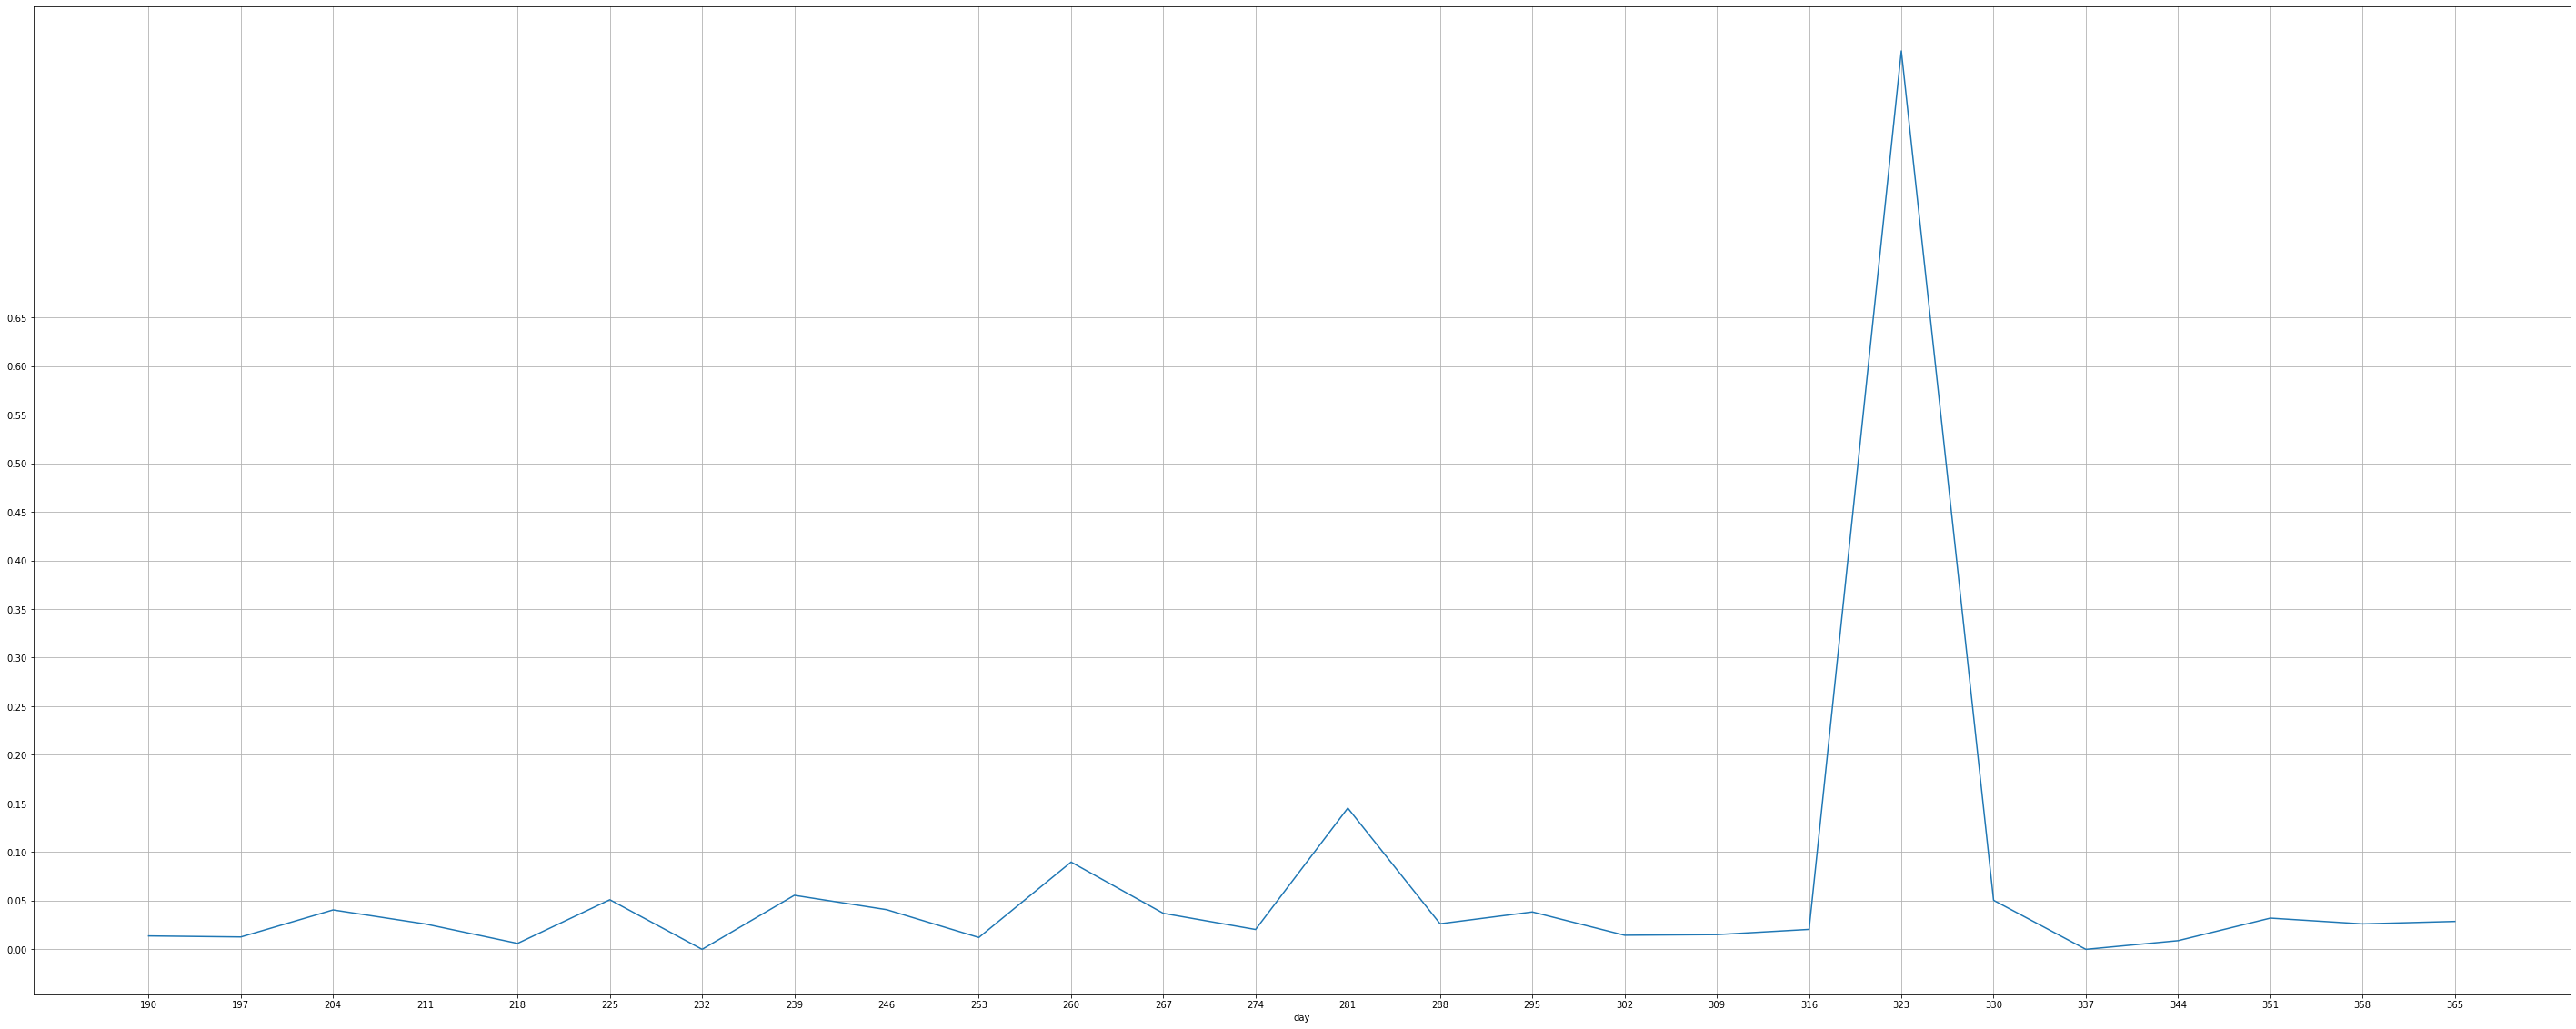

In [26]:
plt.figure(figsize=(50, 20))
train_df9.groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(train_df9['day'].unique())
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

Выброс с 317 по 344 день.

# Разбиение на  train  и  test

In [27]:
TARGET_NAME = 'target'

In [28]:
X_train = train_df9.drop(columns=[TARGET_NAME])
y_train = train_df9[TARGET_NAME]
X_test = test_df9.drop(columns=[TARGET_NAME])
y_test = test_df9[TARGET_NAME]

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

In [29]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0.0    2683
1.0    2484
Name: target, dtype: int64

In [30]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

# Поиск категориальных признаков среди вещественных

In [31]:
df_numerical = X_train.select_dtypes(include = [np.number])
df_categorical = X_train.select_dtypes(exclude = [np.number])

In [32]:
# Ищу признаки категориальные среди вещественных
select_spy = pd.DataFrame(df_numerical.nunique())

In [33]:
list_spy = select_spy.loc[select_spy[0] < 11].index.to_list()

In [34]:
list_spy.remove('vas_id')

In [35]:
#df_categorical = df_all[list_spy]

In [36]:
#df_numerical.drop(labels=list_spy, axis=1, inplace = True)
#вырезаем эти колонки из количественных данных

In [37]:
#df_numerical.drop(labels=['target'], axis=1, inplace = True)

In [38]:
# где у нас нули
#for i in df_numerical.columns:
#    print(i, df4[i][df4[i]==0].count())

In [39]:
# Проверка
Categorical_features = X_train_balanced.select_dtypes(exclude=[np.number])

In [40]:
cat_feats = Categorical_features.columns.to_list()

In [41]:
cat_feats

[]

In [42]:
#df4[list_spy] = df4[list_spy].astype('object')

In [43]:
#categorical_features = df4.select_dtypes(include=['object']).columns.to_list()

In [44]:
list_spy = ['15', '16', '17', '23', '24', '26', '27', '29', '30', '31', '32', '33', '35', '57',
     '65', '75', '81', '85', '95', '131', '132', '139', '154', '155', '179', '192', '194', '195',
     '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '212', '216',
     '218', '220', '221', '252', 'month']

# Выбор модели

In [60]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

4.320450885668277

In [65]:
disbalance2 = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance2

1.0801127214170692

scale_pos_weight не помог

# XGBClassifier

In [45]:
# manually handling imbalance. Below is same as computing float(18501)/392318 
#on the trainig dataset.
# We are going to inversely assign the weights
weight_ratio = float(len(y_train_balanced[y_train_balanced == 0]))/float(len(y_train_balanced[y_train_balanced == 1]))
w_array = np.array([1]*y_train_balanced.shape[0])
w_array[y_train_balanced==1] = weight_ratio
w_array[y_train_balanced==0] = 1- weight_ratio

sample_weight=w_array не повлиял на результат

In [46]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [47]:
feature_importances = train_evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2683
         1.0       1.00      1.00      1.00       621

    accuracy                           1.00      3304
   macro avg       1.00      1.00      1.00      3304
weighted avg       1.00      1.00      1.00      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1785
         1.0       0.88      0.86      0.87       383

    accuracy                           0.95      2168
   macro avg       0.93      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1741   44
1.0      

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


macro avg       0.88      0.65      0.71     87015

In [48]:
#run_cv(model_xgb, kfold_cv, X_train, y_train, model_name="model_xgb");

model_xgb: f1_macro = 0.56 (+/- 0.00)


In [49]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [50]:
feature_importances = train_evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.519257
1.0    0.480743
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:56:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2683
         1.0       1.00      1.00      1.00      2484

    accuracy                           1.00      5167
   macro avg       1.00      1.00      1.00      5167
weighted avg       1.00      1.00      1.00      5167

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.87      0.86      0.87       383

    accuracy                           0.95      2168
   macro avg       0.92      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1736   49
1.0      

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


macro avg       0.77      0.87      0.81     28204

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

In [51]:
#run_cv(model_xgb, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_xgb");

model_xgb: f1_macro = 0.98 (+/- 0.00)



In [52]:
#show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

# LGBMClassifier

In [53]:
model_lgbm = LGBMClassifier(random_state=21)

Регуляризация не повлияла на результат

In [54]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2683
         1.0       1.00      1.00      1.00       621

    accuracy                           1.00      3304
   macro avg       1.00      1.00      1.00      3304
weighted avg       1.00      1.00      1.00      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.88      0.85      0.86       383

    accuracy                           0.95      2168
   macro avg       0.92      0.91      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1739   46
1.0       57  326


 macro avg       0.87      0.65      0.71     75129

In [55]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1 = 0.61 (+/- 0.01)

In [56]:
model_lgbm = LGBMClassifier(random_state=21)

In [57]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.519257
1.0    0.480743
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2683
         1.0       1.00      1.00      1.00      2484

    accuracy                           1.00      5167
   macro avg       1.00      1.00      1.00      5167
weighted avg       1.00      1.00      1.00      5167

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.87      0.87      0.87       383

    accuracy                           0.95      2168
   macro avg       0.92      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1737   48
1.0       51  332


macro avg       0.78      0.87      0.82     28204

In [58]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1_macro = 0.99 (+/- 0.00)

In [59]:
#show_learning_curve_plot(model_lgbm, X_train_balanced, y_train_balanced)

# CatBoostClassifier

In [61]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features': [],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [62]:
model_catb = catb.CatBoostClassifier(**frozen_params)

In [63]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2683
         1.0       0.94      0.99      0.96       621

    accuracy                           0.99      3304
   macro avg       0.97      0.99      0.98      3304
weighted avg       0.99      0.99      0.99      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.87      0.87      0.87       383

    accuracy                           0.95      2168
   macro avg       0.92      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1737   48
1.0       51  332


macro avg       0.76      0.83      0.79     75129

In [79]:
run_cv(model_catb, kfold_cv, X_train, y_train, model_name="model_catb");

model_catb: f1_macro = 0.93 (+/- 0.00)


In [66]:
frozen_params2 = {
     'class_weights':[1, disbalance2], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [67]:
model_catb2 = catb.CatBoostClassifier(**frozen_params2)

In [68]:
feature_importances = train_evaluate_preds(model_catb2, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.519257
1.0    0.480743
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2683
         1.0       0.99      1.00      1.00      2484

    accuracy                           1.00      5167
   macro avg       1.00      1.00      1.00      5167
weighted avg       1.00      1.00      1.00      5167

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.87      0.87      0.87       383

    accuracy                           0.95      2168
   macro avg       0.92      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1737   48
1.0       50  333


macro avg       0.78      0.87      0.81     28204

In [69]:
#run_cv(model_catb2, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_catb");

In [70]:
#show_learning_curve_plot(model_catb, X_train_balanced, y_train_balanced)

# RandomForestClassifier

In [71]:
model_RF = RandomForestClassifier(random_state=21, class_weight={0:.57, 1:.43})

RandomForestClassifier без ccp_alpha дает полное переобучение на трейне, ввел коэффициент.

In [72]:
feature_importances = train_evaluate_preds(model_RF, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.519257
1.0    0.480743
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2683
         1.0       1.00      1.00      1.00      2484

    accuracy                           1.00      5167
   macro avg       1.00      1.00      1.00      5167
weighted avg       1.00      1.00      1.00      5167

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.88      0.86      0.87       383

    accuracy                           0.95      2168
   macro avg       0.93      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1740   45
1.0       53  330


macro avg       0.79      0.83      0.81     75129

In [73]:
#run_cv(model_RF, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_RF");

In [74]:
model_RF2 = RandomForestClassifier(random_state=21, class_weight={0:.57, 1:.43})

In [75]:
feature_importances2 = train_evaluate_preds(model_RF, X_train, X_test, y_train, y_test)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2683
         1.0       1.00      1.00      1.00       621

    accuracy                           1.00      3304
   macro avg       1.00      1.00      1.00      3304
weighted avg       1.00      1.00      1.00      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.88      0.86      0.87       383

    accuracy                           0.95      2168
   macro avg       0.93      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1740   45
1.0       53  330


macro avg       0.49      0.50      0.50     87015

In [76]:
#run_cv(model_RF2, kfold_cv, X_train, y_train, model_name="model_RF");

model_RF2: f1 = 0.52 (+/- 0.01)


In [77]:
#show_learning_curve_plot(model_RF, X_train_balanced, y_train_balanced)

По результатам отборочных туров, главным тренером команды назначен CatBoostClassifier на несбалансированных данных.

# Выбор метода балансировки датасета

In [ ]:
#df_balanced_tomek = balance_df_by_target_advance(df_for_balancing, 'target', method='tomek')

In [ ]:
#X_train_tomek = df_balanced_tomek.drop(columns=TARGET_NAME)
#y_train_tomek = df_balanced_tomek[TARGET_NAME]

In [ ]:
#disbalance_t = y_train_tomek.value_counts()[0] / y_train_tomek.value_counts()[1]
#disbalance_t

In [ ]:
#frozen_params_t = {
 #    'class_weights':[1, disbalance_t], 
  #   'silent':True,
   #  'random_state':21,
    # 'eval_metric':'F1',
    # 'early_stopping_rounds':60
#}

In [ ]:
#model_catb_t = catb.CatBoostClassifier(**frozen_params_t, reg_lambda = 0.1)

In [ ]:
#feature_importances = train_evaluate_preds(model_catb_t, X_train_tomek, X_test, y_train_tomek, y_test)

In [ ]:
#df_smote = balance_df_by_target_advance(df_for_balancing, 'target', method='smote')

In [ ]:
#X_train_smote= df_smote.drop(columns=TARGET_NAME)
#y_train_smote = df_smote[TARGET_NAME]

In [ ]:
#disbalance_s = y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]
#disbalance_s

In [ ]:
#frozen_params_s = {
#     'class_weights':[1, disbalance_s], 
#     'silent':True,
#     'random_state':21,
#     'eval_metric':'F1',
#     'early_stopping_rounds':60
#}

In [ ]:
#model_catb_s = catb.CatBoostClassifier(**frozen_params_s, reg_lambda = 0.1)

In [ ]:
#feature_importances = train_evaluate_preds(model_catb_s, X_train_smote, X_test, y_train_smote, y_test)

In [ ]:
#run_cv(model_catb_s, kfold_cv, X_train_smote, y_train_smote, model_name="model_catb");

In [80]:
#fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [ ]:
#feature_importances = train_evaluate_preds(model_catb_s, X_train_smote[fea_imp], X_test[fea_imp], y_train_smote, y_test)

In [ ]:
#X_train = X_train_smote[fea_imp]
#X_test = X_test[fea_imp]
#y_train = y_train_smote

# Удаление признаков

In [81]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2683
         1.0       0.94      0.99      0.96       621

    accuracy                           0.99      3304
   macro avg       0.97      0.99      0.98      3304
weighted avg       0.99      0.99      0.99      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.87      0.87      0.87       383

    accuracy                           0.95      2168
   macro avg       0.92      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1737   48
1.0       51  332


In [82]:
fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [83]:
len(fea_imp)

214

In [84]:
X_train.shape

(3304, 272)

In [85]:
feature_importances = train_evaluate_preds(model_catb, X_train[fea_imp], X_test[fea_imp], y_train, y_test)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2683
         1.0       0.94      0.99      0.96       621

    accuracy                           0.99      3304
   macro avg       0.97      0.99      0.98      3304
weighted avg       0.99      0.99      0.99      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.88      0.87      0.87       383

    accuracy                           0.96      2168
   macro avg       0.92      0.92      0.92      2168
weighted avg       0.96      0.96      0.96      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1739   46
1.0       51  332


In [86]:
X_train = X_train[fea_imp]
X_test = X_test[fea_imp]

Чемпионат был длинный и часть игроков померла а часть еле дышит. Вызываю санитаров.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [87]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [88]:
lr = LinearRegression()
#select 10 the most informative features
rfe = RFE(lr)
selector = rfe.fit(X_train, y_train)

In [89]:
selector.ranking_

array([103,   1,   1,  61,   1,  74,   1,  62,   1,  76,   1,  57,   1,
         1,   1,  21,   1,   1,   1,   1,  49,  52,   1,   1,   1,   1,
         1,  47,   1, 102,   1,   1,   1,  70,  23,   1,   1,   1,  14,
        59,  75,  81,   1,   1,  33,  18,   1,  31,  17,  38,   4,  71,
         1,   1,   1,   1,   1,   1,   1,  56,  42,   1,   1,   1,  45,
        20,  65,   1,   1,   1,   1,  16,   1,   1,   1,   1,   5,  29,
        60, 100,  67,   1,   1,  37,  34,  51,   2,  22,   1,   6,   1,
         1,   1,   1,   1,  94,   1,   1,   1,   1,   1,   1,   1,  19,
        46,   1,   1,   1,  92,   1,   1,   1,   1,   1,   1,   1,  73,
        26,  58,  66,   1,   1,   1,   1,   1,   1,   1,  72,   1,  32,
         1,   1,   1,   8,  97,   9,  68,   7,  64,  24,  43,   1,   1,
         1,  87,   1,  12,  15,  11,  13,  10,   1,  28,   1,  85,  30,
         1,  25,   1,   1,   1,   1,   1,   1,   1,  54,  99, 101,   1,
        80, 105,  53,  93,   1,  35,   1,   1, 107,  55, 106, 10

In [90]:
value = np.array(X_train.columns.to_list())
mask = selector.support_
last_col = list(value[mask])
last_col.extend(['id'])
X_train_short = X_train[last_col]

In [91]:
X_test_short = X_test[last_col]

In [92]:
feature_importances = train_evaluate_preds(model_catb, X_train_short, X_test_short, y_train, y_test)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2683
         1.0       0.94      0.99      0.96       621

    accuracy                           0.99      3304
   macro avg       0.97      0.99      0.98      3304
weighted avg       0.99      0.99      0.99      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.88      0.87      0.87       383

    accuracy                           0.95      2168
   macro avg       0.92      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1738   47
1.0       51  332


In [93]:
X_train = X_train_short
X_test = X_test_short

In [94]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2683
         1.0       0.94      0.99      0.96       621

    accuracy                           0.99      3304
   macro avg       0.97      0.99      0.98      3304
weighted avg       0.99      0.99      0.99      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.88      0.87      0.87       383

    accuracy                           0.95      2168
   macro avg       0.92      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1738   47
1.0       51  332


/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


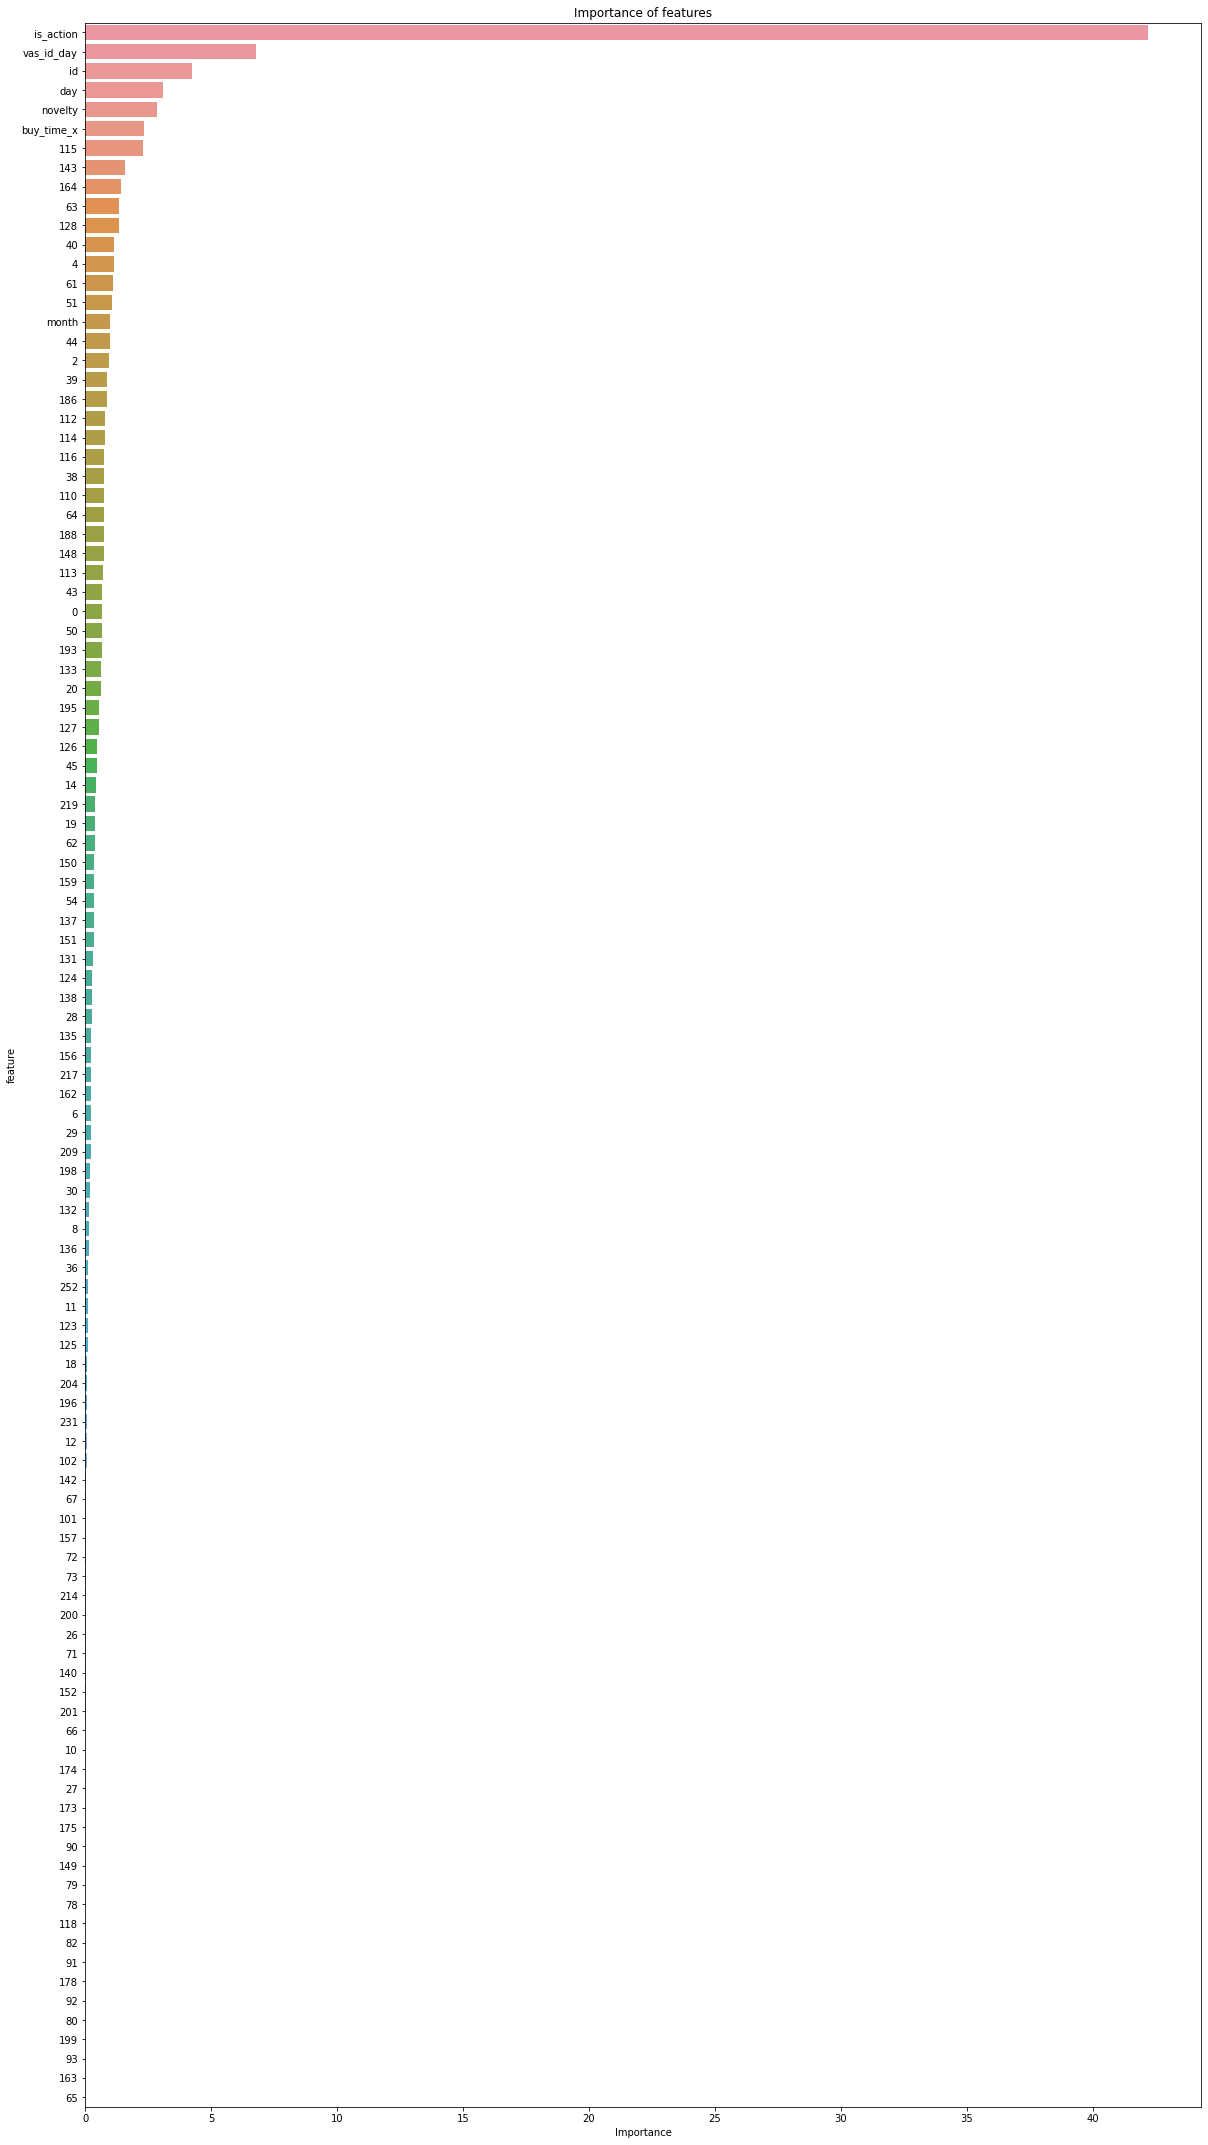

['is_action', 'vas_id_day', 'id', 'day', 'novelty']

In [95]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'], get_top = 5)

# SHAP

In [96]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [97]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_catb)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

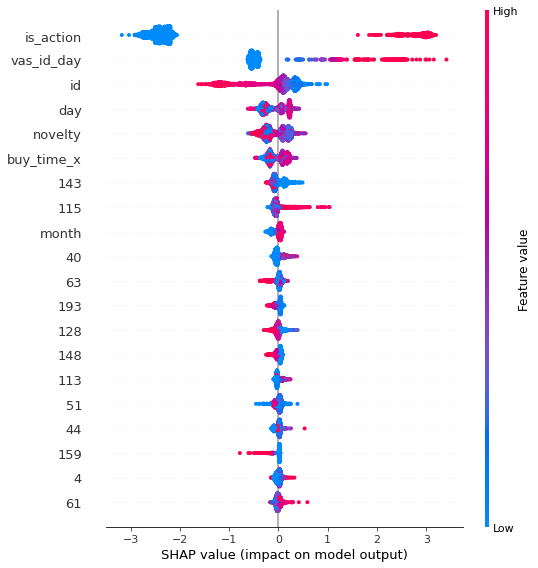

In [98]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать:

    значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
    чем толще линия на графике, тем больше таких точек наблюдения
    чем краснее точка на графике, тем выше значения признака в ней


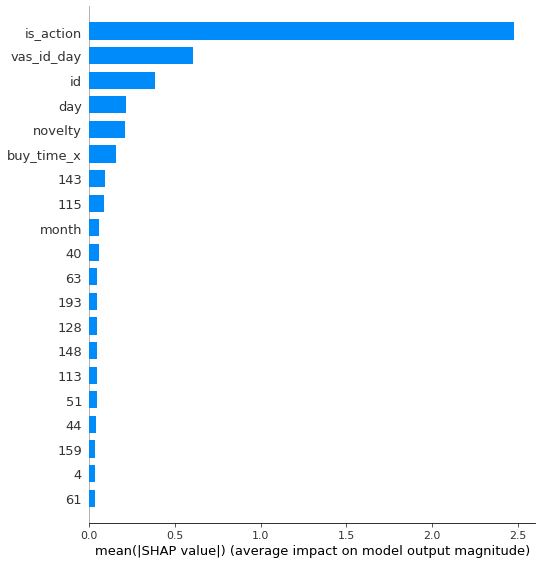

In [99]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [100]:
# Закладка
train_df9 = pd.concat([X_train, y_train], axis=1)
test_df9 = pd.concat([X_test, y_test], axis=1)
train_df9.to_csv('train_df9.csv', index=False)
test_df9.to_csv('test_df9.csv', index=False)

In [101]:
train_df9 = pd.read_csv('train_df9.csv')
test_df9 = pd.read_csv('test_df9.csv')
X_test = test_df9.drop(columns=['target'])
y_test = test_df9['target']
X_train = train_df9.drop(columns=['target'])
y_train = train_df9['target']

# Подбор гиперпараметров

In [102]:
from matplotlib import pyplot

Исследование количества деревьев


In [103]:
# get a list of models to evaluate
def get_models():
    models = dict()
    trees = [50, 100, 200, 500, 1000]
    for n in trees:
        models[str(n)] = catb.CatBoostClassifier(random_state = 21, iterations=n, silent = True)
    return models

In [104]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [105]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>50 0.936 (0.007)
>100 0.932 (0.008)
>200 0.934 (0.005)
>500 0.934 (0.006)
>1000 0.933 (0.007)


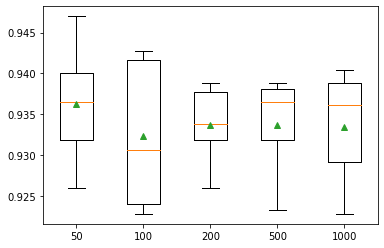

In [106]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование глубины дерева


In [110]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in [2, 4, 6, 8, 10]:
        models[str(i)] = catb.CatBoostClassifier(max_depth=i, num_leaves=2**i,
                                            random_state=21, silent = True)
    return models

In [111]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [112]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>2 0.934 (0.007)
>4 0.934 (0.005)
>6 0.933 (0.007)
>8 0.934 (0.008)


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


>10 0.935 (0.006)


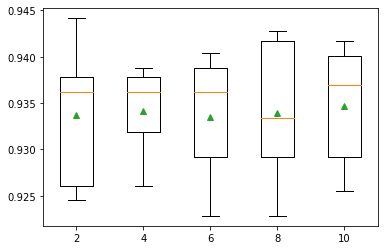

In [113]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование скорости обучения

In [114]:
# get a list of models to evaluate
def get_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = catb.CatBoostClassifier(learning_rate=r,
                                            random_state=21, silent = True)
    return models

In [115]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [116]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0001 0.929 (0.005)
>0.0010 0.931 (0.005)
>0.0100 0.934 (0.006)
>0.1000 0.935 (0.005)
>1.0000 0.929 (0.010)


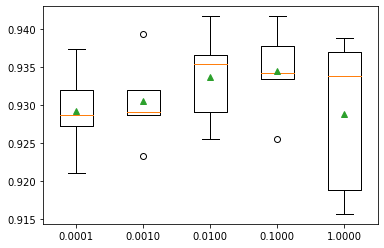

In [117]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование регуляризации

In [118]:
# get a list of models to evaluate
def get_models():
    models = dict()
    types = [0.1,1,2,4,8]
    for t in types:
        models[t] = catb.CatBoostClassifier(l2_leaf_reg=t,
                                            random_state=21, silent=True)
    return models

In [119]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [120]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.1 0.934 (0.009)
>1 0.935 (0.008)
>2 0.935 (0.008)
>4 0.935 (0.008)
>8 0.932 (0.006)


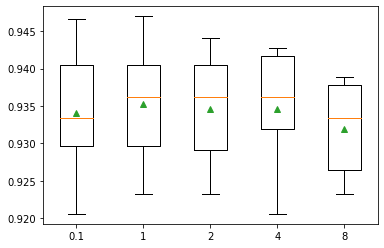

In [121]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [122]:
params = {'n_estimators':[25, 50, 500],
          'max_depth':[3, 4, 10]}

In [125]:
cv=KFold(n_splits=5, random_state=21, shuffle=True)

In [123]:
model_catb = catb.CatBoostClassifier(**frozen_params)

In [126]:
%%time

grid_search = model_catb.randomized_search(params, X_train, y_train, n_iter = 50, cv = cv, stratified = True, plot = True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9239092346
bestIteration = 0

0:	loss: 0.9239092	best: 0.9239092 (0)	total: 235ms	remaining: 1.88s

bestTest = 0.9239092346
bestIteration = 0

1:	loss: 0.9239092	best: 0.9239092 (0)	total: 439ms	remaining: 1.54s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9239092346
bestIteration = 0

2:	loss: 0.9239092	best: 0.9239092 (0)	total: 664ms	remaining: 1.33s

bestTest = 0.9239092346
bestIteration = 0

3:	loss: 0.9239092	best: 0.9239092 (0)	total: 782ms	remaining: 977ms

bestTest = 0.9239092346
bestIteration = 0

4:	loss: 0.9239092	best: 0.9239092 (0)	total: 1.01s	remaining: 811ms
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9239092346
bestIteration = 0

5:	loss: 0.9239092	best: 0.9239092 (0)	total: 1.41s	remaining: 703ms

bestTest = 0.9239092346
bestIteration = 2

6:	loss: 0.9239092	best: 0.9239092 (0)	total: 4s	remaining: 1.14s

bestTest = 0.9239092346
bestIteration = 2

7:	loss: 0.9239092	best: 0.9239092 (0)	total: 8.71s	remainin

In [136]:
best_model = catb.CatBoostClassifier(**frozen_params, n_estimators = 500, max_depth=4)

In [137]:
best_model.fit(X_train, y_train)

In [138]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2683
         1.0       0.92      0.93      0.92       621

    accuracy                           0.97      3304
   macro avg       0.95      0.96      0.95      3304
weighted avg       0.97      0.97      0.97      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.86      0.87      0.86       383

    accuracy                           0.95      2168
   macro avg       0.92      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1732   53
1.0       51  332


# Снижение степени переобучения

In [139]:
params = {'l2_leaf_reg': [4, 5, 6],
         'learning_rate': [0.01, 0.1]
         }

In [140]:
best_model = catb.CatBoostClassifier(**frozen_params, n_estimators = 500, max_depth = 4)

In [141]:
grid_search = best_model.randomized_search(params, X_train, y_train, n_iter = 50, cv = cv, stratified = True, plot = True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9239092346
bestIteration = 0

0:	loss: 0.9239092	best: 0.9239092 (0)	total: 409ms	remaining: 2.04s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9282522069
bestIteration = 28

1:	loss: 0.9282522	best: 0.9282522 (1)	total: 843ms	remaining: 1.69s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9239092346
bestIteration = 0

2:	loss: 0.9239092	best: 0.9282522 (1)	total: 1.16s	remaining: 1.16s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9282522069
bestIteration = 33

3:	loss: 0.9282522	best: 0.9282522 (1)	total: 1.68s	remaining: 842ms
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9239092346
bestIteration = 0

4:	loss: 0.9239092	best: 0.9282522 (1)	total: 2.02s	remaining: 404ms
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9282522069
bestIteration = 39

5:	loss: 0.9282522	best: 0.9282522 (1)	total: 2.6s	remaining: 0u

Поисковые сетки ничего не знают о требованиях Мегафона к average: macro, и ищут взвешенные метрики. Придется обломиться с поиском.

In [146]:
best_model = catb.CatBoostClassifier(**frozen_params,  learning_rate = 0.01, n_estimators = 500, max_depth=4)

In [147]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.812046
1.0    0.187954
Name: target, dtype: float64

0.0    0.823339
1.0    0.176661
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2683
         1.0       0.90      0.89      0.89       621

    accuracy                           0.96      3304
   macro avg       0.94      0.93      0.93      3304
weighted avg       0.96      0.96      0.96      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.86      0.87      0.86       383

    accuracy                           0.95      2168
   macro avg       0.91      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1730   55
1.0       51  332


# Штрафую нули

In [ ]:
#frozen_params = {
#     'class_weights':[1, 1.4], 
#     'silent':True,
#     'random_state':21,
#     #'cat_features': [],
#     'eval_metric':'F1',
#     'early_stopping_rounds':60
#}

In [ ]:
#best_model = catb.CatBoostClassifier(**frozen_params,  learning_rate = 0.1, n_estimators = 50, max_depth=7)

In [ ]:
#feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

In [148]:
run_cv(best_model, kfold_cv, X_train, y_train, model_name="best_model");

best_model: f1_macro = 0.93 (+/- 0.00)


best_model: f1_macro = 0.93 (+/- 0.00)



# Подбор порога

In [149]:
#наши прогнозы для тестовой выборки
preds = best_model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.11018189, 0.95566157, 0.0659493 , 0.06774985, 0.94281805,
       0.94928985, 0.06958009, 0.17102578, 0.07722853, 0.12810163])

In [150]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.888414, F-Score=0.872, Precision=0.882, Recall=0.862


In [151]:
def predict_proba_to_int(y_predicted_probs, threshold):
         return (y_predicted_probs > threshold)*1

In [152]:
# Нашли метки предсказания для лучшего порога
best_predict = predict_proba_to_int(preds, thresholds[ix])

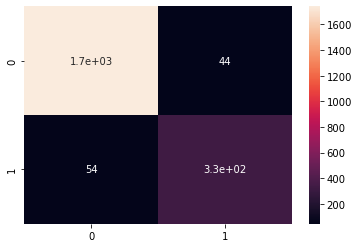

In [153]:
sns.heatmap(confusion_matrix(y_test, best_predict), annot=True)
plt.show()

Модернизирую функцию evaluate_preds для получения скоров с учетом лучшего вероятностного порога.

In [154]:
def evaluate_preds_with_threshold(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_poba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test,\
                                                           y_test_poba)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    best_predict = predict_proba_to_int(y_test_poba, thresholds[ix])
    

    get_classification_report(y_train, y_train_pred, y_test, best_predict)
    print('Best Threshold=%f' % (thresholds[ix]))
    
    return best_predict

In [155]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2683
         1.0       0.90      0.89      0.89       621

    accuracy                           0.96      3304
   macro avg       0.94      0.93      0.93      3304
weighted avg       0.96      0.96      0.96      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1785
         1.0       0.86      0.87      0.86       383

    accuracy                           0.95      2168
   macro avg       0.91      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1730   55
1.0       51  332


In [156]:
best_predict = evaluate_preds_with_threshold(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2683
         1.0       0.90      0.89      0.89       621

    accuracy                           0.96      3304
   macro avg       0.94      0.93      0.93      3304
weighted avg       0.96      0.96      0.96      3304

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1785
         1.0       0.88      0.86      0.87       383

    accuracy                           0.95      2168
   macro avg       0.93      0.92      0.92      2168
weighted avg       0.95      0.95      0.95      2168

CONFUSION MATRIX

col_0      0    1
target           
0.0     1741   44
1.0       54  329
Best Threshold=0.888414


Не удалось повысить метрику.

Написал функцию для тонкой настройки трешхолда

In [ ]:
def predict_proba_compare(model, X_test, X_train, y_test, y_train, cut_off):
    # функция изменения линии отсечки при расчете таргета
    pred_proba_test = model.predict_proba(X_test)
    y_test_proba=np.where(pred_proba_test[:, 1] > cut_off, 1, 0)
    pred_proba_train = model.predict_proba(X_train)
    y_train_proba=np.where(pred_proba_train[:, 1] > cut_off, 1, 0)
    print('TRAIN\n\n' + classification_report(y_train, y_train_proba))
    print('TEST\n\n' + classification_report(y_test, y_test_proba))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_proba))
    
    return y_train_proba, y_test_proba

In [ ]:
predict_proba_compare(best_model, X_test, X_train, y_test, y_train, 0.54)

С трешхолдом нет смысла возиться.

In [168]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [169]:
y_test_poba = best_model.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[1730   55]
 [  51  332]]


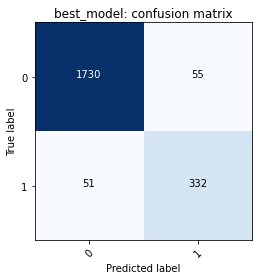

In [170]:
cm = confusion_matrix(y_test, y_test_poba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

# СОЗДАЮ ПАЙПЛАЙН

На несбалансированных данных! 


In [158]:
columns9 = ['buy_time_x', '0', '2', '4', '6', '8', '10', '11', '12', '14', '18', '19',
     '20', '26', '27', '28', '29', '30', '36', '38', '39', '40', '43', '44', '45',
     '50', '51', '54', '61', '62', '63', '64', '65', '66', '67', '71', '72', '73',
     '78', '79', '80', '82', '90', '91', '92', '93', '101', '102', '110', '112', '113',
     '114', '115', '116', '118', '123', '124', '125', '126', '127', '128', '131', '132',
     '133', '135', '136', '137', '138', '140', '142', '143', '148', '149', '150',
     '151', '152', '156', '157', '159', '162', '163', '164', '173', '174', '175',
     '178', '186', '188', '193', '195', '196', '198', '199', '200', '201', '204',
     '209', '214', '217', '219', '231', '252', 'month', 'day', 'novelty', 'vas_id_day',
     'is_action', 'id']

In [159]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [160]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [161]:
Selected_Columns = Pipeline([
                ('selector', ColumnSelector(columns9))
            ])

In [162]:
pipeline = Pipeline([
    ('Selected_Columns', Selected_Columns),
    ('classifier', catb.CatBoostClassifier(class_weights = [1, 4.32], random_state = 21, eval_metric = 'F1',  learning_rate = 0.01, n_estimators = 500, max_depth=4))
])

# Сохранение модели

In [4]:
import pickle

In [164]:
with open('model_9.pkl', 'wb') as model:
    pickle.dump(pipeline, model)

In [165]:
with open('model_9.pkl', 'rb') as model:
    x = pickle.load(model)

In [166]:
x.fit(X_test, y_test)

0:	learn: 0.9097174	total: 9.2ms	remaining: 4.59s
1:	learn: 0.9097174	total: 19.4ms	remaining: 4.84s
2:	learn: 0.9097174	total: 28ms	remaining: 4.63s
3:	learn: 0.9097174	total: 38ms	remaining: 4.71s
4:	learn: 0.9097174	total: 46.3ms	remaining: 4.59s
5:	learn: 0.9097174	total: 51.8ms	remaining: 4.26s
6:	learn: 0.9097174	total: 56.4ms	remaining: 3.98s
7:	learn: 0.9097174	total: 62ms	remaining: 3.81s
8:	learn: 0.9097174	total: 66.2ms	remaining: 3.61s
9:	learn: 0.9097174	total: 70.1ms	remaining: 3.44s
10:	learn: 0.9097174	total: 74.3ms	remaining: 3.3s
11:	learn: 0.9097174	total: 78.4ms	remaining: 3.19s
12:	learn: 0.9097174	total: 82.8ms	remaining: 3.1s
13:	learn: 0.9097174	total: 87.2ms	remaining: 3.02s
14:	learn: 0.9097174	total: 91.6ms	remaining: 2.96s
15:	learn: 0.9097174	total: 95.7ms	remaining: 2.9s
16:	learn: 0.9097174	total: 99.9ms	remaining: 2.84s
17:	learn: 0.9097174	total: 104ms	remaining: 2.79s
18:	learn: 0.9097174	total: 109ms	remaining: 2.75s
19:	learn: 0.9097174	total: 113ms	

185:	learn: 0.9097174	total: 786ms	remaining: 1.33s
186:	learn: 0.9097174	total: 792ms	remaining: 1.33s
187:	learn: 0.9097174	total: 797ms	remaining: 1.32s
188:	learn: 0.9097174	total: 802ms	remaining: 1.32s
189:	learn: 0.9097174	total: 808ms	remaining: 1.32s
190:	learn: 0.9097174	total: 812ms	remaining: 1.31s
191:	learn: 0.9097174	total: 815ms	remaining: 1.31s
192:	learn: 0.9097174	total: 820ms	remaining: 1.3s
193:	learn: 0.9097174	total: 825ms	remaining: 1.3s
194:	learn: 0.9097174	total: 828ms	remaining: 1.29s
195:	learn: 0.9097174	total: 833ms	remaining: 1.29s
196:	learn: 0.9097174	total: 838ms	remaining: 1.29s
197:	learn: 0.9097174	total: 842ms	remaining: 1.28s
198:	learn: 0.9097174	total: 846ms	remaining: 1.28s
199:	learn: 0.9097174	total: 850ms	remaining: 1.27s
200:	learn: 0.9097174	total: 854ms	remaining: 1.27s
201:	learn: 0.9097174	total: 858ms	remaining: 1.27s
202:	learn: 0.9097174	total: 862ms	remaining: 1.26s
203:	learn: 0.9097174	total: 867ms	remaining: 1.26s
204:	learn: 0.

376:	learn: 0.9156957	total: 1.56s	remaining: 510ms
377:	learn: 0.9156957	total: 1.57s	remaining: 506ms
378:	learn: 0.9156957	total: 1.57s	remaining: 502ms
379:	learn: 0.9156957	total: 1.57s	remaining: 498ms
380:	learn: 0.9156957	total: 1.58s	remaining: 494ms
381:	learn: 0.9156957	total: 1.58s	remaining: 490ms
382:	learn: 0.9156957	total: 1.59s	remaining: 486ms
383:	learn: 0.9156957	total: 1.59s	remaining: 482ms
384:	learn: 0.9156957	total: 1.6s	remaining: 478ms
385:	learn: 0.9156957	total: 1.6s	remaining: 474ms
386:	learn: 0.9156957	total: 1.61s	remaining: 470ms
387:	learn: 0.9156957	total: 1.61s	remaining: 466ms
388:	learn: 0.9156957	total: 1.62s	remaining: 462ms
389:	learn: 0.9156957	total: 1.62s	remaining: 457ms
390:	learn: 0.9156957	total: 1.63s	remaining: 453ms
391:	learn: 0.9156957	total: 1.63s	remaining: 449ms
392:	learn: 0.9156957	total: 1.63s	remaining: 445ms
393:	learn: 0.9156957	total: 1.64s	remaining: 441ms
394:	learn: 0.9156957	total: 1.64s	remaining: 436ms
395:	learn: 0.

Pipeline(steps=[('Selected_Columns',
                 Pipeline(steps=[('selector',
                                  ColumnSelector(key=['buy_time_x', '0', '2',
                                                      '4', '6', '8', '10', '11',
                                                      '12', '14', '18', '19',
                                                      '20', '26', '27', '28',
                                                      '29', '30', '36', '38',
                                                      '39', '40', '43', '44',
                                                      '45', '50', '51', '54',
                                                      '61', '62', ...]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fbe2ae81ac0>)])

Confusion matrix, without normalization
[[1731   54]
 [  47  336]]


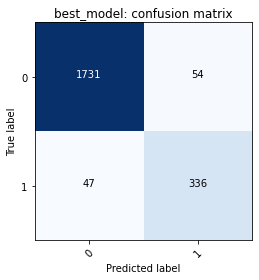

In [171]:
y_test_proba = x.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

In [5]:
frozen_params = {
     'class_weights':[1, 4.32], 
     'silent':True,
     'random_state':21,
     #'cat_features': [],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [6]:
best_model = catb.CatBoostClassifier(**frozen_params,  learning_rate = 0.01, n_estimators = 500, max_depth=4)

In [7]:
with open('model9.pkl','wb') as model:
    pickle.dump(best_model,model)

In [ ]:
with open('model9.pkl', 'rb') as model:
    loaded_model = pickle.load(model)

In [ ]:
y_test_proba = loaded_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");